In [1]:
# started here https://medium.com/@tomgrek/building-your-first-neural-net-from-scratch-with-pytorch-56b0e9c84d54

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torch.optim as optim

%matplotlib inline


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,1)
        self.fc2 = nn.Linear(1,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

In [ ]:
class SkipNet(nn.Module):
    def __init__(self):
        super(SkipNet, self).__init__()
        self.fc1 = nn.Linear(1,1024)
        self.fc2 = nn.Linear(1024,1)
        self.linear_gain = nn.Linear(1,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x)))) + self.linear_gain(x) 
        return x

In [9]:
#net = Net().cuda()
net = Net()
#skipnet = SkipNet()
print(list(net.parameters()))

[Parameter containing:
tensor([[-0.5292]], requires_grad=True), Parameter containing:
tensor([0.4254], requires_grad=True), Parameter containing:
tensor([[-0.0370]], requires_grad=True), Parameter containing:
tensor([-0.4664], requires_grad=True)]


In [10]:
input = Variable(torch.randn(1,1,1), requires_grad=True)
print(input)
out = net(input)
print(out)


tensor([[[0.1181]]], requires_grad=True)
tensor([[[0.]]], grad_fn=<ReluBackward>)


In [16]:
def criterion(out, label):
    return (label - out)**2


criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
#skipoptimizer = optim.SGD(skipnet.parameters(), lr=0.01, momentum=0.5)

In [22]:
data = [(1,3), (2,6), (3,9), (4,12), (5,15), (6,18)]
loss_hist = []
weight_hist1 = []
weight_hist2 = []

In [23]:
for epoch in range(100):
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True).cuda(), Variable(torch.FloatTensor([Y]), requires_grad=False).cuda()
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)

        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.data)
        weight_hist1.append(net.fc1.weight)
        weight_hist2.append(net.fc2.weight)
        #if (i % 10 == 0):
           # print("Epoch {} - loss: {}".format(epoch, loss.data[0]))

In [ ]:
# for the skip network
skip_loss_hist = []
skip_weight_hist1 = []
skip_weight_hist2 = []

for epoch in range(100):
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True).cuda(), Variable(torch.FloatTensor([Y]), requires_grad=False).cuda()
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)

        skipoptimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        skipoptimizer.step()
        
        skip_loss_hist.append(loss.data[0])
        skip_weight_hist1.append(net.fc1.weight)
        skip_weight_hist2.append(net.fc2.weight)
        if (i % 10 == 0):
            print("Epoch {} - loss: {}".format(epoch, loss.data[0]))


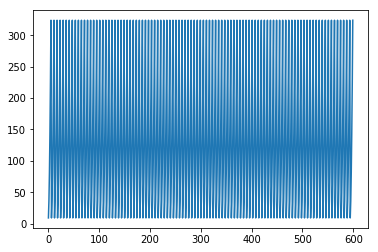

In [24]:
plt.plot(loss_hist)


In [ ]:
plt.plot(skip_loss_hist)

In [ ]:
plt.plot(skip_weight_hist1[0])

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,1)
        self.fc2 = nn.Linear(1,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
    
criterion = nn.MSELoss()
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
data = [(1,3), (2,6), (3,9), (4,12), (5,15), (6,18)]

for epoch in range(100):
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if (i % 10 == 0):
            print("Epoch {} - loss: {}".format(epoch, loss.data[0]))

Epoch 0 - loss: 9.0
Epoch 1 - loss: 9.0
Epoch 2 - loss: 9.0
Epoch 3 - loss: 9.0
Epoch 4 - loss: 9.0
Epoch 5 - loss: 9.0
Epoch 6 - loss: 9.0
Epoch 7 - loss: 9.0
Epoch 8 - loss: 9.0
Epoch 9 - loss: 9.0
Epoch 10 - loss: 9.0
Epoch 11 - loss: 9.0
Epoch 12 - loss: 9.0
Epoch 13 - loss: 9.0
Epoch 14 - loss: 9.0
Epoch 15 - loss: 9.0
Epoch 16 - loss: 9.0
Epoch 17 - loss: 9.0
Epoch 18 - loss: 9.0
Epoch 19 - loss: 9.0
Epoch 20 - loss: 9.0
Epoch 21 - loss: 9.0
Epoch 22 - loss: 9.0
Epoch 23 - loss: 9.0
Epoch 24 - loss: 9.0
Epoch 25 - loss: 9.0
Epoch 26 - loss: 9.0
Epoch 27 - loss: 9.0
Epoch 28 - loss: 9.0
Epoch 29 - loss: 9.0
Epoch 30 - loss: 9.0
Epoch 31 - loss: 9.0
Epoch 32 - loss: 9.0
Epoch 33 - loss: 9.0
Epoch 34 - loss: 9.0
Epoch 35 - loss: 9.0
Epoch 36 - loss: 9.0
Epoch 37 - loss: 9.0
Epoch 38 - loss: 9.0
Epoch 39 - loss: 9.0
Epoch 40 - loss: 9.0
Epoch 41 - loss: 9.0
Epoch 42 - loss: 9.0
Epoch 43 - loss: 9.0
Epoch 44 - loss: 9.0
Epoch 45 - loss: 9.0
Epoch 46 - loss: 9.0
Epoch 47 - loss: 9.0
Ep

/home/sgillen/work_dir/ucsb/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
